# Online Phase for PBDW and TR-GEIM: GPR recovery
This notebook takes the Snapshots, and investigate the reconstruction for failed measurements for PBDW and TR-GEIM with GPR recovery.

Let us create the mesh from the OpenFOAM nodes and cells

In [1]:
from pyforce.tools.write_read import ReadFromOF
from IPython.display import clear_output as clc
from pyforce.tools.backends import  LoopProgress

from matplotlib import cm, rcParams, pyplot as plt
import pickle

path_snaps = '../../../Data/MSFR/'
of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')
domain = of.create_mesh()

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/ufl/__init__.py:244: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('../ReflectorSensing/Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('../ReflectorSensing/Results/times.npz')['fom_times']

measured_filed = [0]
var_names = [var_names[i] for i in measured_filed]
is_vector = [is_vector[i] for i in measured_filed]

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('../ReflectorSensing/Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train and test and predict.

In [3]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)

_indices = np.arange(0, Nt)
train_indices, test_indices = train_test_split(_indices, test_size=0.25, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

train_snaps = dict()
for field_i, field in enumerate(var_names):
    train_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in train_indices:
        train_snaps[field].append(snaps[field](ii) / snaps[field](0).max())
        
test_snaps = dict()

for field_i, field in enumerate(var_names):
    test_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in test_indices:
        test_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

Let us perfome the GEIM offline to select 4 additional measurements to use for the GPR recovery.

In [4]:
from pyforce.offline.geim import GEIM as GEIMoffline

geim_offline = {
    field: GEIMoffline(domain, fun_spaces[field_i], field, s=0.025)
    for field_i, field in enumerate(var_names)
}

def is_out_core(node):
    return (((node[2] <= -1.13) or (node[2] >=  1.13) or (node[0] >= 2.05)) and
            ((node[1]<=0.02) or (node[1]>=-0.02)))

nodes = domain.geometry.x
out_core = np.array([is_out_core(node) for node in nodes])
out_core_idx = np.where(out_core)[0]
in_core_idx  = np.where(~out_core)[0]

xm_list = list()

for tag in out_core_idx[::50]: 
    xm_list.append(nodes[tag])

Mext = 4
for field_i, field in enumerate(var_names):
    geim_offline[field].offline(train_snaps[field], Mext, xm=xm_list, verbose=True)

Generating sensors (coinstrained cells): 542.000 / 542.00 - 0.018 s/it


Let us load the magic functions and sensors

In [5]:
from pyforce.tools.write_read import ImportH5

strategy = 'ID'

magic_fun = dict()
magic_sen = dict()

for field_i, field in enumerate(var_names):
    magic_fun[field] = ImportH5(fun_spaces[field_i], f'Results/GEIM_offline/GEIM_{field}_{strategy}_mf',
                                f'GEIM_{field}_{strategy}_mf')[0]
    magic_sen[field] = ImportH5(fun_spaces[field_i], f'Results/GEIM_offline/GEIM_{field}_{strategy}_ms',
                                f'GEIM_{field}_{strategy}_ms')[0]

Let us load the GEIM training coefficients

In [6]:
training_betas = {field: np.load(f'Results/GEIM_offline/GEIM_{field}_{strategy}_TrainBeta.npz')['arr_0']
                  for field in var_names}

mean_beta = {field: np.mean(training_betas[field], axis=0)
                for field in var_names}
std_beta = {field: np.std(training_betas[field], axis=0)
                for field in var_names}

Let us load the POD modes and the SGREEDY sensors

In [7]:
pod_modes = dict()
sgreedy_sens = dict()

for field_i, field in enumerate(var_names):
    pod_modes[field] = ImportH5(fun_spaces[field_i], f'Results/POD_offline/POD_{field}_modes',
                                f'POD_{field}_modes')[0]
    sgreedy_sens[field] = ImportH5(fun_spaces[field_i], f'Results/POD_offline/SGREEDY_{field}_sensors',
                                   f'SGREEDY_{field}_sensors')[0]

Let us set the noise level and the field

In [8]:
noise_level = 1e-3

field_i = 0
field = var_names[field_i]

perfect_recons = dict()
failure_recons = dict()
remove_recons = dict()

M=15
N=5

## Train the GPR model to recover the missing information

Let us create the additional measurements

In [9]:
from pyforce.tools.backends import norms, LoopProgress

_norm = norms(fun_spaces[field_i])

train_ext_measurements = np.zeros((len(train_snaps[field]), Mext))

failed_sens_i = 0
train_failed_measurements = np.zeros((len(train_snaps[field]), 1))

bar = LoopProgress(final = len(train_snaps[field]), msg='Computing Train Measurements')
for ii in range(len(train_snaps[field])):
    train_failed_measurements[ii, 0] = _norm.L2innerProd(magic_sen[field](failed_sens_i), train_snaps[field](ii))

    for mm in range(Mext):
        train_ext_measurements[ii, mm] = _norm.L2innerProd(geim_offline[field].magic_sens(mm), train_snaps[field](ii))

    bar.update(1)

Computing Train Measurements: 206.000 / 206.00 - 0.050 s/it


Add random noise to the measurements

In [10]:
train_ext_measurements = train_ext_measurements + noise_level * np.random.randn(*train_ext_measurements.shape)
train_failed_measurements = train_failed_measurements + noise_level * np.random.randn(*train_failed_measurements.shape)

Train the GPR model

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the kernel for the Gaussian Process
kernel = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-6, 1e2)) + WhiteKernel(
                                noise_level=1, noise_level_bounds=(1e-3, 1e2))

_gpr_train_indices, _gpr_valid_indices = train_test_split(np.arange(len(train_ext_measurements)), test_size=0.2, random_state=42)

gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-8, normalize_y=True)
gpr_model.fit(train_ext_measurements[_gpr_train_indices], 
              train_failed_measurements[_gpr_train_indices])

,kernel,1**2 * RBF(le...noise_level=1)
,alpha,1e-08
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,1**2 * RBF(length_scale=1)
,kernel__k2,WhiteKernel(noise_level=1)
,kernel__k1__k1,1**2


Plot the GPR predictions on the validation set

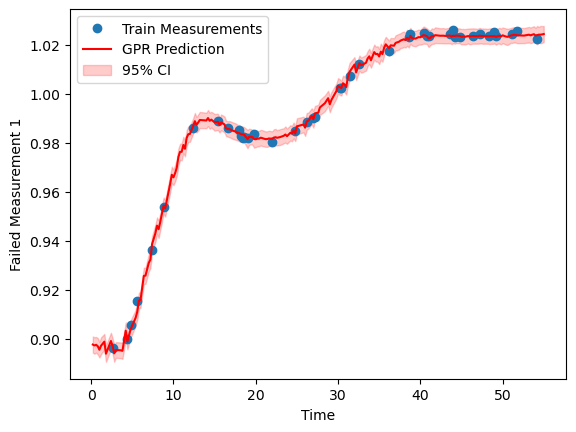

In [13]:
gpr_predict = gpr_model.predict(train_ext_measurements, return_std=True)

plt.plot(fom_times[train_indices[np.sort(_gpr_valid_indices)]], train_failed_measurements[np.sort(_gpr_valid_indices)], 'o', label='Train Measurements')
plt.plot(fom_times[train_indices], gpr_predict[0], 'r-', label='GPR Prediction')
plt.fill_between(fom_times[train_indices],
                    gpr_predict[0] - 2 * gpr_predict[1],
                    gpr_predict[0] + 2 * gpr_predict[1], color='r', alpha=0.2, label='95% CI')

plt.xlabel('Time')
plt.ylabel(f'Failed Measurement {failed_sens_i+1}')
plt.legend()

## Perfect Scenario

### TR-GEIM
The Tikhonov regularization for the Generalized Empirical Interpolation Method (TR-GEIM) is used to reconstruct the snapshots.

In [25]:
from pyforce.online.tr_geim import TRGEIM

perfect_trgeim = TRGEIM(magic_fun[field], magic_sen[field], name=field,
                  mean_beta=mean_beta[field], std_beta=std_beta[field])

perfect_recons['TR-GEIM'] = FunctionsList(fun_spaces[field_i])

bar = LoopProgress(final=len(test_snaps[field]), msg=f'Reconstruction perfect TR-GEIM {field}')

for tt in range(len(test_snaps[field])):
    perfect_recons['TR-GEIM'].append(
        perfect_trgeim.reconstruct(test_snaps[field](tt), noise_value=noise_level,
                                   reg_param=noise_level**2, M=M)[0]
    )
    bar.update(1)

Reconstruction perfect TR-GEIM T: 69.000 / 69.00 - 0.163 s/it


### PBDW
The Parameterised-Background Data-Weak (PBDW) method is used to reconstruct the snapshots.

In [16]:
from pyforce.online.pbdw import PBDW

perfect_pbdw = PBDW(pod_modes[field], sgreedy_sens[field], name=field)

perfect_recons['PBDW'] = FunctionsList(fun_spaces[field_i])

bar = LoopProgress(final=len(test_snaps[field]), msg=f'Reconstruction perfect PBDW {field}')

for tt in range(len(test_snaps[field])):
    perfect_recons['PBDW'].append(
        perfect_pbdw.reconstruct(test_snaps[field](tt), noise_value=noise_level,
                                   reg_param=10, M=M, N=N)[0]
    )
    bar.update(1)

Reconstruction perfect PBDW T: 69.000 / 69.00 - 0.153 s/it


## Failed Sensors - GPR reconstruction
In this scenario, one sensor breaks, the failed measure is recovered with GPR and how the reconstruction is affected is investigated.

In [17]:
failed_sens_i = [0]

### TR-GEIM

In [18]:
from pyforce.online.failing_sensors import TRGEIM

failing_trgeim = TRGEIM(magic_fun[field], magic_sen[field], name=field,
                  mean_beta=mean_beta[field], std_beta=std_beta[field])

failure_recons['TR-GEIM'] = failing_trgeim.gpr_measure_test_err(test_snaps[field], M=M, noise_value=noise_level,
                                                              reg_param=noise_level**2, ext_sens=geim_offline[field].magic_sens,
                                                              surrogate_model=[gpr_model],
                                                              idx_failed=failed_sens_i, verbose=True)[1]

Computing TR-GEIM ml-remove (synthetic) - T: 69.000 / 69.00 - 0.012 s/it


### PBDW

In [19]:
from pyforce.online.failing_sensors import PBDW

failing_pbdw = PBDW(pod_modes[field], sgreedy_sens[field], name=field)

failure_recons['PBDW'] = failing_pbdw.gpr_measure_test_err(test_snaps[field], M=M, N=N, noise_value=noise_level,
                                                           reg_param=10 * np.ones(M), ext_sens=geim_offline[field].magic_sens,
                                                           surrogate_model=[gpr_model],
                                                           idx_failed=failed_sens_i, verbose=True)[1]

Computing PBDW remove (synthetic) - T: 69.000 / 69.00 - 0.022 s/it


## Plot comparison

Let us make a contour plot of the reconstructed field for TR-GEIM

In [50]:
from utils import plot_contour

mesh_plot = np.concatenate((domain.geometry.x[:, 0].reshape(-1,1), domain.geometry.x[:, 2].reshape(-1,1)), axis=1)

cmap = cm.jet

_min = min([test_snaps[field](-1).min(),
            failure_recons['TR-GEIM'](-1).min(),
           failure_recons['PBDW'](-1).min()]) * 0.95
_max = max([test_snaps[field](-1).max(),
           failure_recons['TR-GEIM'](-1).max(),
           failure_recons['PBDW'](-1).max()]) * 1.025

levels = np.linspace(_min, _max, 40)

save_gif = True
path_figs = 'Results/OnlineReconstruction/'

import os
os.makedirs(path_figs, exist_ok=True)

sampling = 3
for tt in range(sampling-1, len(test_snaps[field]), sampling):

    fig, axs = plt.subplots(2,5, figsize=(6 * 5, 10))

    # FOM and recons
    cont = plot_contour(axs[0, 0], mesh_plot, test_snaps[field](tt), cmap=cmap, levels=levels, full_core=False)
    plot_contour(axs[0, 1], mesh_plot, perfect_recons['TR-GEIM'](tt), cmap=cmap, levels=levels, full_core=False)
    plot_contour(axs[0, 2], mesh_plot, failure_recons['TR-GEIM'](tt), cmap=cmap, levels=levels, full_core=False)
    plot_contour(axs[0, 3], mesh_plot, perfect_recons['PBDW'](tt), cmap=cmap, levels=levels, full_core=False)
    plot_contour(axs[0, 4], mesh_plot, failure_recons['PBDW'](tt), cmap=cmap, levels=levels, full_core=False)

    for ax in axs[0]:
        cbar = fig.colorbar(cont, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=20)
        cbar.locator.set_params(nbins=5)
        cbar.update_ticks()

    # Residuals
    axs[1,0].axis('off')
    res_cont = plot_contour(axs[1, 1], mesh_plot, 
                np.abs(perfect_recons['TR-GEIM'](tt) - test_snaps[field](tt)), cmap= cm.hot, levels=40, full_core=False)
    cbar = fig.colorbar(res_cont, ax=axs[1,1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator.set_params(nbins=5)
    cbar.update_ticks()

    res_cont = plot_contour(axs[1, 2], mesh_plot, 
                np.abs(failure_recons['TR-GEIM'](tt) - test_snaps[field](tt)), cmap= cm.hot, levels=40, full_core=False)
    cbar = fig.colorbar(res_cont, ax=axs[1,2], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator.set_params(nbins=5)
    cbar.update_ticks()

    res_cont = plot_contour(axs[1, 3], mesh_plot, 
                np.abs(perfect_recons['PBDW'](tt) - test_snaps[field](tt)), cmap= cm.hot, levels=40, full_core=False)
    cbar = fig.colorbar(res_cont, ax=axs[1,3], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator.set_params(nbins=5)
    cbar.update_ticks()

    res_cont = plot_contour(axs[1, 4], mesh_plot, 
                np.abs(failure_recons['PBDW'](tt) - test_snaps[field](tt)), cmap= cm.hot, levels=40, full_core=False)
    cbar = fig.colorbar(res_cont, ax=axs[1,4], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator.set_params(nbins=5)
    cbar.update_ticks()

    fig.text(0.2, 0.35, f'Time $t={fom_times[test_indices[tt]]:.2f}$ s\nFailed Sensor #{failed_sens_i[0]+1}', fontsize=30, ha='center',
            bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='round,pad=0.5'))

    axs[0, 0].set_title('FOM', fontsize=25)
    axs[0, 1].set_title('Perfect TR-GEIM', fontsize=25)
    axs[0, 2].set_title('TR-GEIM (GPR recovery)', fontsize=25)
    axs[0, 3].set_title('Perfect PBDW', fontsize=25)
    axs[0, 4].set_title('PBDW (GPR recovery)', fontsize=25)

    fig.subplots_adjust(wspace=0.15, hspace=0.15)

    if save_gif:
        fig.savefig(f'{path_figs}FailedSensing_{tt+1:04d}.png', bbox_inches='tight', dpi=100)
    else:
        plt.show()
        clc(wait=True)
    plt.close(fig)

Let us make a gif from the contour plots

In [55]:
import imageio.v2 as imageio

# Create the GIF by loading each image and adding it to the array
def create_gif(gif_path, path_imgs, image_files, duration=150.):
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for img_file in image_files:
            img_path = os.path.join(path_imgs, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

if save_gif:

    path_figs = 'Results/OnlineReconstruction/'
    image_files = sorted(os.listdir(path_figs), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    path_gif = 'Media/'
    os.makedirs(path_gif, exist_ok=True)
    create_gif(path_gif+'OnlineReconstruction.gif', path_figs, image_files, duration=100.)